In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [2]:
# Workout actual mean and std of dataset

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),])

dataset = Flowers102(root='', split='train', transform=transform, download=False)

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in dataset:
    channel_sum += torch.mean(img, dim=(1, 2))
    channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
    count += 1

mean = channel_sum / count
std = torch.sqrt(channel_sum_squared / count - mean ** 2)

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4330, 0.3819, 0.2964])
Std: tensor([0.2952, 0.2473, 0.2742])


In [3]:
train_transform = v2.Compose([
		 v2.ToImage(),
		 v2.RandomResizedCrop(size=(224, 224), antialias=True),
		 v2.RandomHorizontalFlip(p=0.5),
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),
])

transform = v2.Compose([
		 v2.ToImage(),
		 v2.Resize((224, 224)),
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),

])

In [4]:
training_data = Flowers102( root='', split='train', transform=train_transform, download=True)
testing_data = Flowers102(root='',split='test',transform=transform,download=True)
evaluation_data = Flowers102(root='',split='val',transform=transform,download=True)

In [5]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


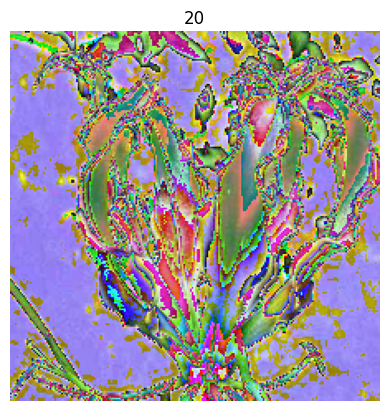

In [6]:
img, label = training_data[160]
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()

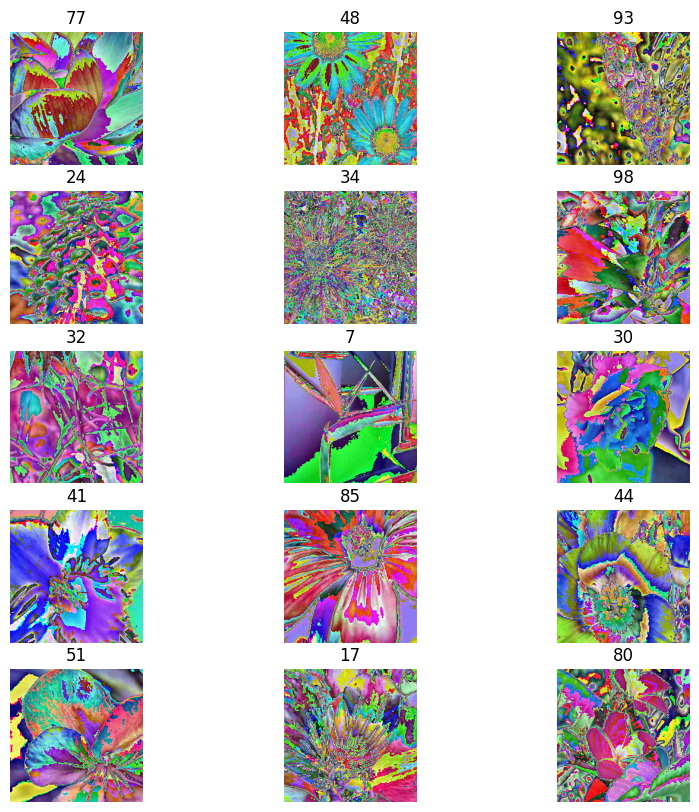

In [7]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]

	np_img = img.permute(1, 2, 0).numpy()
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((np_img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

In [8]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
		super(FlowerClassifier, self).__init__()
		self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
		self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.fc1 = nn.Linear(256 * 28 * 28, 512)
		self.fc2 = nn.Linear(512, 102)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = self.pool(F.relu(self.conv3(x)))
		x = x.view(-1, 256 * 28 * 28)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return F.log_softmax(x, dim=1)

In [9]:
training_loader = DataLoader(training_data, batch_size=128, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=128, shuffle=False)

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


In [11]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=10):
	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

In [12]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=30)

Epoch 1/30, Training Loss: 6.5286, Evaluation Loss: 4.6187, Val Accuracy: 0.0176
Epoch 2/30, Training Loss: 4.5724, Evaluation Loss: 4.4949, Val Accuracy: 0.0186
Epoch 3/30, Training Loss: 4.3902, Evaluation Loss: 4.2963, Val Accuracy: 0.0431
Epoch 4/30, Training Loss: 4.1741, Evaluation Loss: 4.0835, Val Accuracy: 0.0657
Epoch 5/30, Training Loss: 4.0203, Evaluation Loss: 4.0369, Val Accuracy: 0.0716
Epoch 6/30, Training Loss: 3.9044, Evaluation Loss: 3.8670, Val Accuracy: 0.0980
Epoch 7/30, Training Loss: 3.7044, Evaluation Loss: 3.8064, Val Accuracy: 0.1078
Epoch 8/30, Training Loss: 3.6313, Evaluation Loss: 3.7871, Val Accuracy: 0.1157
Epoch 9/30, Training Loss: 3.5835, Evaluation Loss: 3.7090, Val Accuracy: 0.1382
Epoch 10/30, Training Loss: 3.4609, Evaluation Loss: 3.5791, Val Accuracy: 0.1520
Epoch 11/30, Training Loss: 3.4586, Evaluation Loss: 3.6357, Val Accuracy: 0.1441
Epoch 12/30, Training Loss: 3.3651, Evaluation Loss: 3.4697, Val Accuracy: 0.1725
Epoch 13/30, Training Los